In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path="malgun.ttf"
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

### 전세/월세 기준 데이터 프레임 생성 함수

In [ ]:
def rent(filename):
    file=filename
    data=pd.read_excel(file, header=16)
    
    data['계약년월'] = pd.to_datetime(data['계약년월'], format='%Y%m')
    monthly = data[data['전월세구분']=='월세']
    
# 월세 : month_df 에 컬럼 추가 후 시군구 컬럼에서 동구만 추출
    month_df = monthly[['시군구', '전용면적(㎡)', '계약년월','전월세구분','월세(만원)', '건축년도' ]]
    month_df['시군구']=month_df['시군구'].apply(lambda v : v.split()[1])
    month_df = month_df[month_df['시군구']!='군위군']
    month_df = month_df.drop(columns='전월세구분', axis=1)

# 전세 : annually_df 에 컬럼 추가 후 시군구 컬럼에서 동구만 추출    
    annually = data[data['전월세구분']=='전세']
    annually_df = annually[['시군구','전용면적(㎡)', '계약년월','전월세구분','보증금(만원)', '건축년도' ]]
    annually_df['시군구']=annually['시군구'].apply(lambda v : v.split()[1])
    annually_df['보증금(만원)'] = annually_df['보증금(만원)'].apply(lambda x:int(x.replace(',', '')))
    annually_df = annually_df[annually_df['시군구']!='군위군']
    annually_df = annually_df.drop(columns='전월세구분', axis=1)

    
    return month_df, annually_df

### 아파트 매매 데이터프레임에서 평당금액 컬럼을 추가한 데이터프레임 생성 함수

In [7]:
def average_amount(filename):
    file=filename
    data=pd.read_excel(file, header=16)
    # 필요한 컬럼 추출 후 시군구 컬럼에서 동구만 추출
    df = data[['시군구','전용면적(㎡)','거래금액(만원)', '건축년도' ]]
    df['시군구']=data['시군구'].apply(lambda v : v.split()[1])
    df['거래금액(만원)'] = df['거래금액(만원)'].apply(lambda x:int(x.replace(',', '')))
    # 평당금액 컬럼을 만들어서 면적당거래금액을 생성
    df['평당금액']=df['거래금액(만원)']/df['전용면적(㎡)']
    df_sorted = df.sort_index(ascending=True)
    # 2017~2023년 사이 건축년도를 정렬한 후 년도별 평당금액 평균 컬럼 생성
    test_list=df_sorted['건축년도'].unique().tolist()
    test_list=sorted(test_list)[:]
    df_sorted=df_sorted[df_sorted['건축년도'].isin(test_list)]
    df_sorted['평당금액_평균'] = df_sorted.groupby('건축년도')['평당금액'].transform('mean')
    # 중복되는 년도 제거 후 데이터 프레임 생성
    new_df=df_sorted[['건축년도', '평당금액_평균']]
    new_df= new_df.drop_duplicates().reset_index(drop=True)
    new_df['건축년도']=sorted(new_df['건축년도'])
    
    new_df=new_df.set_index('건축년도')
    new_df.rename(columns={'평당금액_평균':df['시군구'][0]}, inplace=True)
    
    return new_df



### 시군구별 아파트 매매  데이터프레임 병합

In [8]:
def merge_data():
    jungu_df=average_amount('대구광역시_아파트매매(중구).xlsx')
    dongu_df=average_amount('대구광역시_아파트매매(동구).xlsx')
    soosung_df=average_amount('대구광역시_아파트매매(수성구).xlsx')
    seogu_df=average_amount('대구광역시_아파트매매(서구).xlsx')
    bookgu_df=average_amount('대구광역시_아파트매매(북구).xlsx')
    dalseogu_df=average_amount('대구광역시_아파트매매(달서구).xlsx')
    dalsunggun_df=average_amount('대구광역시_아파트매매(달성군).xlsx')
    namgu_df=average_amount('대구광역시_아파트매매(남구).xlsx')
    
    merged_dfs = [jungu_df, dongu_df, seogu_df, bookgu_df, dalseogu_df,namgu_df, soosung_df, dalsunggun_df ]
    merged_df = pd.concat(merged_dfs, axis=1, sort=True).fillna(0)
    
    df_replaced = merged_df.replace(0, np.nan)
    df_filled = df_replaced.fillna(method='ffill')
    
    selected_rows = df_filled.iloc[-7:]
    return selected_rows
    

In [14]:
selected_rows=merge_data()
selected_rows

C:\Users\LG\anaconda3\envs\MY_PYTHON\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\LG\AppData\Local\Temp\ipykernel_10324\4165741612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['시군구']=data['시군구'].apply(lambda v : v.split()[1])
C:\Users\LG\AppData\Local\Temp\ipykernel_10324\4165741612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['

C:\Users\LG\AppData\Local\Temp\ipykernel_10324\4165741612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['시군구']=data['시군구'].apply(lambda v : v.split()[1])
C:\Users\LG\AppData\Local\Temp\ipykernel_10324\4165741612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['거래금액(만원)'] = df['거래금액(만원)'].apply(lambda x:int(x.replace(',', '')))
C:\Users\LG\AppData\Local\Temp\ipykernel_10324\4165741612.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,중구,동구,서구,북구,달서구,남구,수성구,달성군
건축년도,,,,,,,,
2017,265.134439,490.714808,342.174145,451.510107,547.307427,301.204819,847.956924,333.535981
2018,565.783174,433.783687,342.174145,451.510107,547.307427,301.204819,508.674145,244.581259
2019,565.783174,433.783687,342.174145,451.510107,390.021431,318.316586,452.517902,244.581259
2020,586.421942,306.873199,342.174145,414.909920,476.586201,397.332792,314.839457,174.097665
2021,333.834084,215.729377,342.174145,405.367310,476.586201,343.169993,466.580557,290.992030
2022,599.423620,270.178994,426.597654,405.367310,267.407179,414.711796,466.580557,290.992030
2023,567.922528,200.290931,360.664762,405.367310,267.407179,414.711796,466.580557,308.085685


### 시군구별 아파트 매매 건축년도 당 평당금액 평균 그래프 시각화

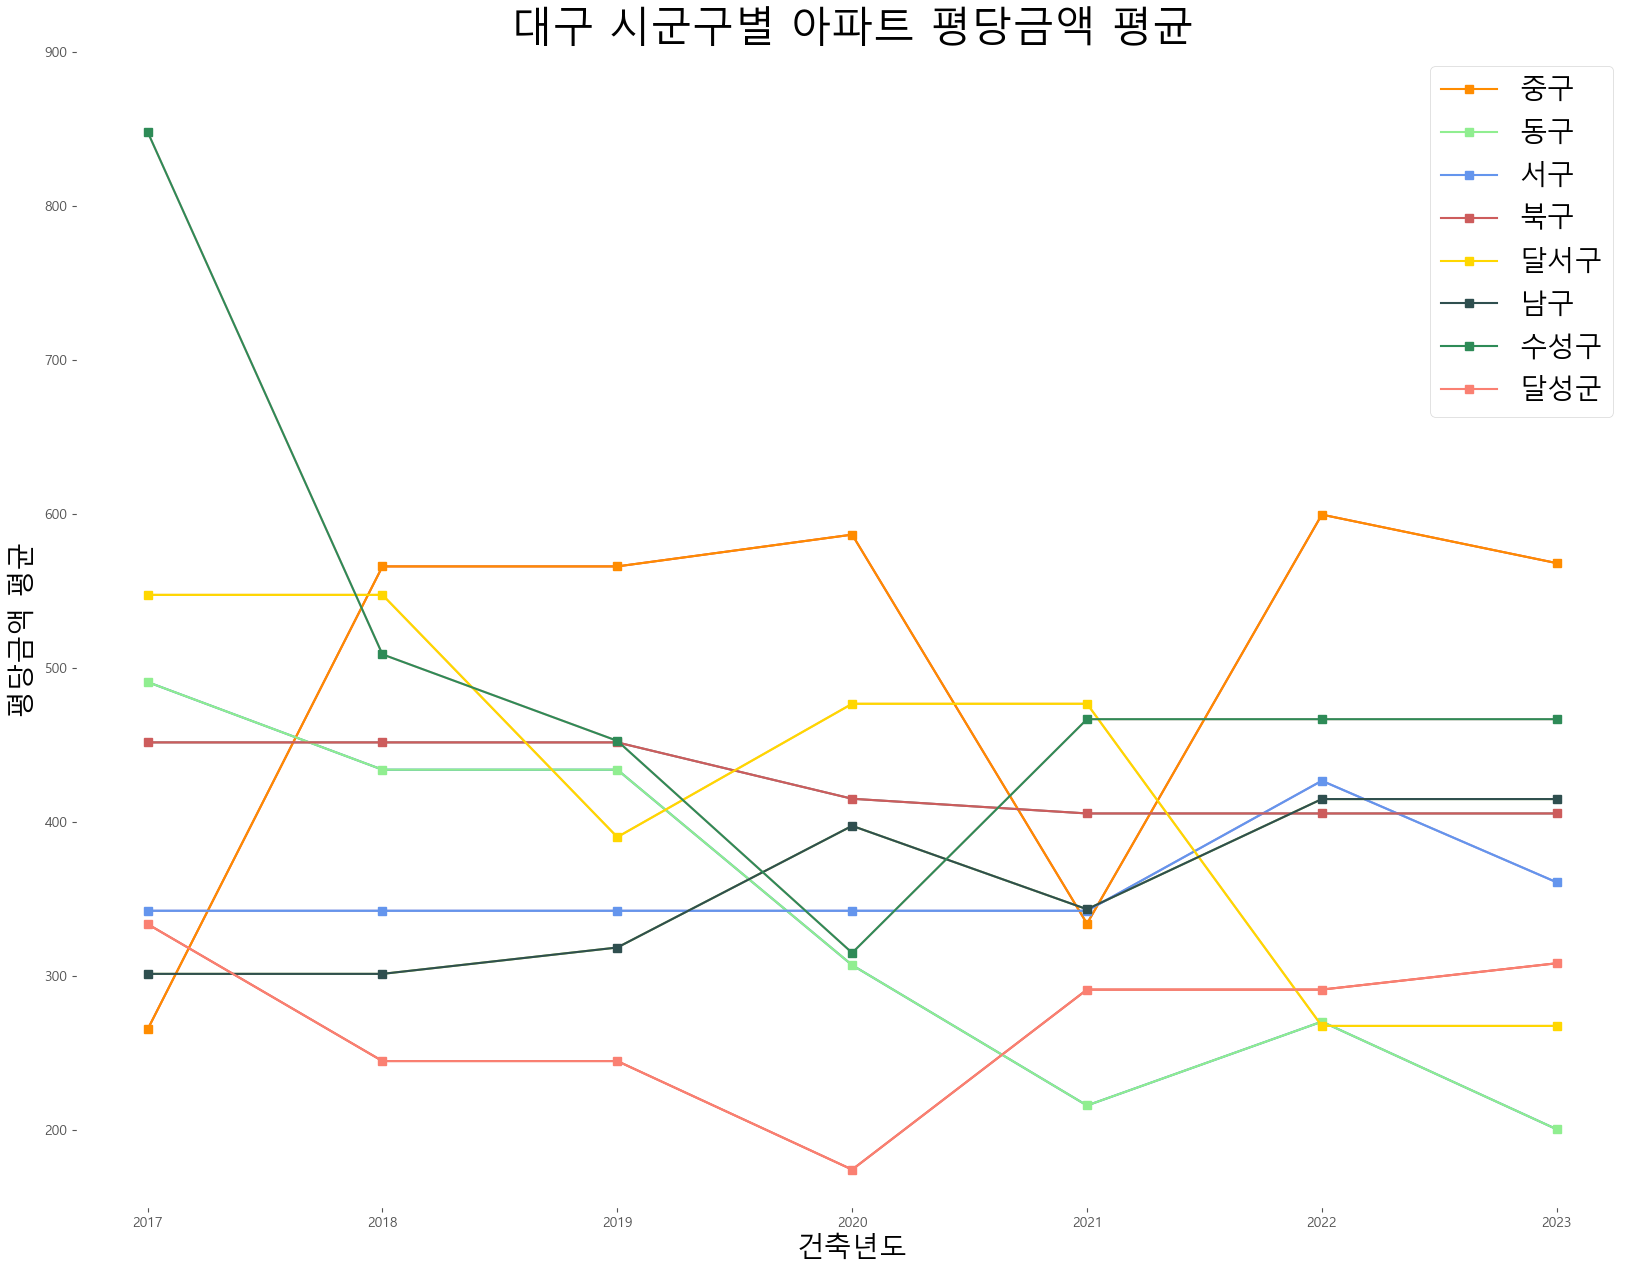

In [69]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(selected_rows.index, selected_rows[['중구', '동구', '서구', '북구', '달서구', '남구', '수성구', '달성군']])

ax = plt.gca()  # 현재 축 가져오기
# ax.spines['top'].set_visible(False)  # 상단 라인 제거
# ax.spines['right'].set_visible(False)  # 오른쪽 라인 제거
ax.spines['bottom'].set_linestyle('--')  # x축 라인 스타일 설정
ax.spines['left'].set_linestyle('--')  # y축 라인 스타일 설정



# selected_columns = ['중구', '동구', '서구', '북구', '달서구', '남구', '수성구', '달성군']
# selected_rows[selected_columns].plot(kind='line')

plt.plot(selected_rows.index, selected_rows['중구'], label='중구', marker='s', color='darkorange')
plt.plot(selected_rows.index, selected_rows['동구'], label='동구', marker='s', color='lightgreen')
plt.plot(selected_rows.index, selected_rows['서구'], label='서구', marker='s', color='cornflowerblue')
plt.plot(selected_rows.index, selected_rows['북구'], label='북구', marker='s', color='indianred')
plt.plot(selected_rows.index, selected_rows['달서구'], label='달서구', marker='s', color='gold')
plt.plot(selected_rows.index, selected_rows['남구'], label='남구', marker='s', color='darkslategrey')
plt.plot(selected_rows.index, selected_rows['수성구'], label='수성구', marker='s', color='seagreen')
plt.plot(selected_rows.index, selected_rows['달성군'], label='달성군', marker='s', color='salmon')

plt.legend(loc='upper right', fontsize=20)
plt.title('대구 시군구별 아파트 평당금액 평균', fontsize=30)
plt.xlabel('건축년도', color='black', fontsize=20)
plt.ylabel('평당금액 평균', color='black', fontsize=20)
plt.ylim(150,900)
# plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

